In [ ]:
import time,os, pickle
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torchsummary import summary
from PIL import Image
import random

class Task():
    def __init__(self, tid=-1, arrive_time = -1, start_time = -1, finish_time = -1):
        # self.model_name = model_name
        self.tid = tid
        self.arrive_time = arrive_time
        self.start_time = start_time
        self.finish_time = finish_time
        self.infer_time = -1
        self.queue_time = -1

    def finalize(self, if_print=True):
        self.infer_time = self.finish_time - self.start_time
        self.queue_time = self.start_time - self.arrive_time
        if if_print: print('infer time: ', self.infer_time, 'queue time: ', self.queue_time)


In [ ]:
with open('./homomodel_result/results_0.2_4.pkl', 'rb') as file: 
    results = pickle.load(file)
infer_times = [r.infer_time for r in results.values()]
print(np.sum(infer_times)/len(infer_times))
print(infer_times)

In [ ]:
with open('./homomodel_result/results_0.3_4.pkl', 'rb') as file: 
    results = pickle.load(file)
infer_times = [r.infer_time for r in results.values()]
print(np.sum(infer_times)/len(infer_times))
print(infer_times)

In [ ]:
with open('./homomodel_result/results_0.4_20.pkl', 'rb') as file: 
    results = pickle.load(file)
infer_times = [r.infer_time for r in results.values()]
print(np.sum(infer_times)/len(infer_times))
print(infer_times)

In [ ]:
with open('./homomodel_result/results_0.4_4.pkl', 'rb') as file: 
    results = pickle.load(file)
infer_times = [r.infer_time for r in results.values()]
print(np.sum(infer_times)/len(infer_times))
print(infer_times)

In [ ]:
with open('./homomodel_result/results_0.4_8.pkl', 'rb') as file: 
    results = pickle.load(file)
infer_times = [r.infer_time for r in results.values()]
print(np.sum(infer_times)/len(infer_times))
print(infer_times)

In [ ]:
with open('./homomodel_result/results_0.4_12.pkl', 'rb') as file: 
    results = pickle.load(file)
infer_times = [r.infer_time for r in results.values()]
print(np.sum(infer_times)/len(infer_times))
print(infer_times)

In [ ]:
with open('./homomodel_result/results_0.4_16.pkl', 'rb') as file: 
    results = pickle.load(file)
infer_times = [r.infer_time for r in results.values()]
print(np.sum(infer_times)/len(infer_times))
print(infer_times)

In [ ]:
# model = models.resnet50(weights=None)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 10) 
model = torch.load('./weights/resnet50.pth')
for i, (name, param) in enumerate(model.named_parameters()):
    print(i, name, param.requires_grad)

In [ ]:
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
detail_layers = []

for i, child in enumerate(list(model.children())):
    if len(list(child.children())) == 0:
        print(i, child)
        detail_layers.append(child)
    else: # 
        for j, sub_child in enumerate(list(child.children())):
            print(i,j, sub_child)
            print('***********************************')
            detail_layers.append(sub_child)
print('**********************************************************************************')

In [ ]:
for layer in detail_layers:
    print(layer)

In [ ]:
model = models.resnet101(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)


slice_model = nn.Sequential(*list(model.children())[:-5])


for i, child in enumerate(list(slice_model.children())):
    print(i,child)

# for i, module in enumerate(list(next_layer.modules())):
#     print(i,module)

for i, module in enumerate(list(slice_model.modules())):
    try:
        final_features = module.num_features
    except:
        pass
print('final_features: ',final_features)

next_layer = nn.Sequential(*list(model.children())[-5])
for i, module in enumerate(list(next_layer.modules())):
    print(i,module)

In [ ]:
model = models.mobilenet_v2(weights=None)
model.classifier[1] = nn.Linear(model.last_channel, 10)

for i, module in enumerate(list(model.modules())):
    print(i,module)

In [ ]:
# for i, child in enumerate(list(model.children())[:-1]):
#     print(i,child)
for i, child in enumerate(list(model.children())):
    for j, sub_child in enumerate(list(child.children())):
        print(i,j,sub_child)

In [ ]:
class EarlyExitMobileNet(nn.Module):
    def __init__(self, original_model, exit_layer = -5, num_classes=10):
        super(EarlyExitMobileNet, self).__init__()
        # expand MobileNet
        detail_layers = []
        for i, child in enumerate(list(original_model.children())):
            for j, sub_child in enumerate(list(child.children())):
                detail_layers.append(sub_child)

        self.features = nn.Sequential(*detail_layers[:exit_layer])
        exit_channel = detail_layers[exit_layer-1].out_channels
        print(f'exit_channel: {exit_channel}')
        print(self.features)
        # Freeze the features part
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Early exit branch
        # self.exit = nn.Sequential(*detail_layers[exit_layer:])
        self.early_exit = nn.Sequential(
            nn.Conv2d(exit_channel, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False),  # Conv layer with 512 output channels
            nn.BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),                            # BatchNorm layer
            nn.ReLU6(inplace=True),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=num_classes, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        # Early exit logic
        early_exit_output = self.early_exit(x)
        
        # Continue with the remaining layers
        # main_exit_output = self.main_exit(x)
        
        return early_exit_output# , main_exit_output

# 定义新的模型
num_classes = 10  # 根据你的任务更改类别数量
exit_layer = -3
ee_model = EarlyExitMobileNet(model, exit_layer, num_classes)

# print(type(ee_model))
# for i, child in enumerate(list(ee_model.children())):
#     for j, sub_child in enumerate(list(child.children())):
#         print(i,j,sub_child)

In [ ]:
for i in range(-15,-3,1):
    print(i)

In [ ]:
detail_layers = list(range(20))
print(detail_layers[:-15])
print(detail_layers[-15])
print(detail_layers[-15:-3])
print(detail_layers[-3:])

In [ ]:
import matplotlib
matplotlib.use('Agg', force=True)
import matplotlib.pyplot as plt
import numpy as np
import json
with open('./profile_results/results/resnet50_vgg19_parallel_2_batch_1.json', 'r') as file:
    result_json = json.load(file)
per_worker = result_json['per_worker']

In [ ]:
per_worker[1][2442]

In [ ]:
durations = [float(item['duration']) for item in per_worker[0]]
print('mean: ', np.mean(durations))
print('std_ms: ', np.std(durations)*1000)

In [ ]:
# variance and mean of worker 0 which is resbet50
print(per_worker[0][2468]['task_id'])
durations = [float(item['duration']) for item in per_worker[1]][:2442]
print('mean: ', np.mean(durations))
print('std_ms: ', np.std(durations)*1000)
durations = [float(item['duration']) for item in per_worker[1]][2442:]
print('mean: ', np.mean(durations))
print('std_ms: ', np.std(durations)*1000)

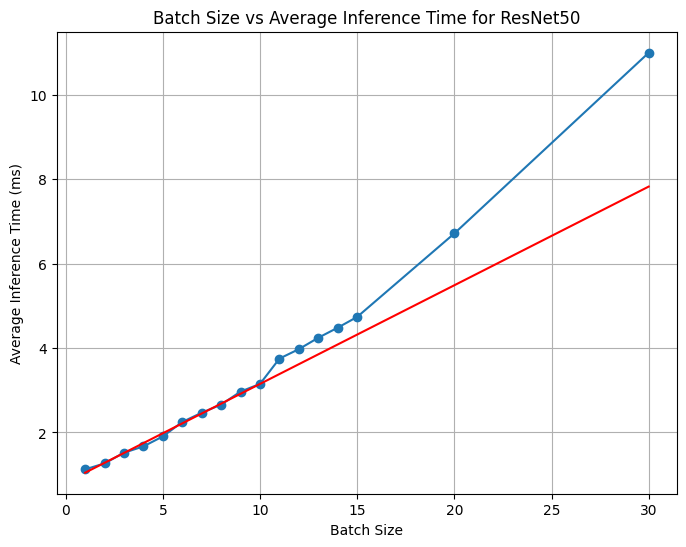

In [14]:
import numpy as np
import matplotlib,json,os
# matplotlib.use('Agg', force=True)
import matplotlib.pyplot as plt

# read results in ./profile_results/results/ and get average inference time
results_files = os.listdir('./profile_results/results/')

batch_sizes = []
inference_times = []
for f in results_files:
    name_parts = f.split('_')
    if name_parts[0] == 'resnet50' and name_parts[2] == '1':
        pass
    else:
        continue
    with open(f'./profile_results/results/{f}', 'r') as file:
        data = json.load(file)
        batch_sizes.append(data["meta"]["batch"])
        inference_times.append(data["summary"]["mean_ms"])
# sort by batch size
batch_sizes, inference_times = zip(*sorted(zip(batch_sizes, inference_times)))

# plot
plt.figure(figsize=(8,6))
plt.plot(batch_sizes[:-2], inference_times[:-2], marker='o')


# 只用前 10 个点做一次线性回归
x = np.asarray(batch_sizes[:10], dtype=float)
y = np.asarray(inference_times[:10], dtype=float)
coef = np.polyfit(x, y, 1)          # coef[0] 是斜率，coef[1] 是截距
fit_fn = np.poly1d(coef)

x_line = np.linspace(min(batch_sizes), max(batch_sizes[:-2]), 400)
plt.plot(x_line, fit_fn(x_line), color='r', linestyle='-', label='1st-order fit (first 10)')
plt.xlabel('Batch Size')
plt.ylabel('Average Inference Time (ms)')
plt.title('Batch Size vs Average Inference Time for ResNet50')
plt.grid(True)

plt.savefig('resnet50_inference_time_vs_batch_size.png')
plt.show()
